In [1]:
# Uncomment to run the notebook in Colab
# ! pip install -q "wax-ml[complete]@git+https://github.com/eserie/wax-ml.git"
# ! pip install -q --upgrade jax jaxlib==0.1.70+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [2]:
%matplotlib inline

In [3]:
import io
import warnings
from collections import defaultdict
from pathlib import Path
from typing import Any, Callable, NamedTuple, Optional, TypeVar

In [ ]:
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy as onp
import optax
import pandas as pd
import plotnine as gg
import requests
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

In [5]:
from wax.accessors import register_wax_accessors
from wax.compile import jit_init_apply
from wax.encode import Encoder
from wax.modules import Buffer, FillNanInf, Lag, RollingMean
from wax.unroll import unroll

In [6]:
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
jax.devices()

jax backend cpu


# 🔭 Reconstructing the light curve of stars with LSTM 🔭

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/05_reconstructing_the_light_curve_of_stars.ipynb)

Let's take a walk through the stars...

This notebook is based on the study done in
[this post by Christophe Pere](https://towardsdatascience.com/how-to-use-deep-learning-for-time-series-forecasting-3f8a399cf205)
and the notebook available on
[the authors's github](https://github.com/Christophe-pere/Time_series_RNN).

We will repeat this study on starlight using the LSTM architecture to predict the observed light flux through time.

Our LSTM implementation is based on this [notebook from Haiku's github repository](https://github.com/deepmind/dm-haiku/blob/master/examples/haiku_lstms.ipynb).

We'll see how to use WAX-ML to ease the preparation of time series data stored in dataframes and having Nans
before calling a "standard" deep-learning workflow.

## Disclaimer

Despite the fact that this code works with real data, the results presented here should not be considered as scientific knowledge insights, to the knowledge of the authors of WAX-ML, neither the results nor the data source have been reviewed by an astrophysics pair.

The purpose of this notebook is only to demonstrate how WAX-ML can be used when applying a "standard" machine learning workflow, here LSTM, to analyze time series.

## Download the data

In [7]:
register_wax_accessors()

In [8]:
# Parameters
STAR = "007609553"
SEQ_LEN = 64
BATCH_SIZE = 8
TRAIN_SIZE = 2**16
NUM_EPOCHS = 10
NUM_STARS = None
RECORD_FREQ = 100
TOTAL_LEN = None
TRAIN_DATE = "2016"
CACHE_DIR = Path("./cached_data/")

In [9]:
%%time
filename = CACHE_DIR / "kep_lightcurves.parquet"
try:
    raw_dataframe = pd.read_parquet(open(filename, "rb"))
    print(f"data read from {filename}")
except FileNotFoundError:
    # Downloading the csv file from Chrustioge Pere GitHub account
    download = requests.get(
        "https://raw.github.com/Christophe-pere/Time_series_RNN/master/kep_lightcurves.csv"
    ).content
    raw_dataframe = pd.read_csv(io.StringIO(download.decode("utf-8")))
    # set date index
    raw_dataframe.index = pd.Index(
        pd.date_range("2009-03-07", periods=len(raw_dataframe.index), freq="h"),
        name="time",
    )
    # save dataframe locally in CACHE_DIR
    CACHE_DIR.mkdir(exist_ok=True)
    raw_dataframe.to_parquet(filename)
    print(f"data saved in {filename}")

data read from cached_data/kep_lightcurves.parquet
CPU times: user 55.3 ms, sys: 32.2 ms, total: 87.5 ms
Wall time: 40.8 ms


In [10]:
# shortening of data to speed up the execution of the notebook in the CI
if TOTAL_LEN:
    raw_dataframe = raw_dataframe.iloc[:TOTAL_LEN]

Let's visualize the description of this dataset:

In [11]:
raw_dataframe.describe().T.to_xarray()

<xarray.Dataset>
Dimensions:  (index: 52)
Coordinates:
  * index    (index) object '001430305_orig' ... '011611275_res'
Data variables:
    count    (index) float64 6.48e+04 5.674e+04 ... 5.673e+04 5.673e+04
    mean     (index) float64 6.776e+04 -0.2265 0.01231 ... 0.001437 0.004351
    std      (index) float64 1.363e+03 15.42 15.27 12.45 ... 4.648 6.415 4.904
    min      (index) float64 6.529e+04 -123.3 -75.59 ... -20.32 -31.97 -20.89
    25%      (index) float64 6.619e+04 -9.488 -9.875 ... -3.269 -4.281 -3.279
    50%      (index) float64 6.806e+04 -0.3476 0.007812 ... 0.007812 -0.06529
    75%      (index) float64 6.882e+04 8.988 10.02 8.092 ... 2.872 4.277 3.213
    max      (index) float64 7.021e+04 128.7 72.31 69.34 ... 26.53 30.94 29.45

In [12]:
stars = raw_dataframe.columns
stars = sorted(list(set([i.split("_")[0] for i in stars])))
print(f"The number of stars available is: {len(stars)}")
print(f"star identifiers: {stars}")

The number of stars available is: 13
star identifiers: ['001430305', '001724719', '005209845', '007596240', '007609553', '008241079', '008247770', '009345933', '009347009', '009349482', '009349757', '010024701', '011611275']


In [13]:
dataframe = raw_dataframe[[i + "_rscl" for i in stars]].rename(
    columns=lambda c: c.replace("_rscl", "")
)
dataframe.columns.names = ["star"]
dataframe.shape

(71427, 13)

In [14]:
if NUM_STARS:
    columns = dataframe.columns.tolist()
    columns.remove(STAR)
    dataframe = dataframe[[STAR] + columns[: NUM_STARS - 1]]

## Rolling mean

We will smooth the data by applying a rolling mean with a window of 100 periods.

### Count nan values

But before since the dataset has some nan values, we will extract few statistics
about the density of nan values in windows of size 100.

It will be the occasion to show a usage of the `wax.modules.Buffer` module with the `format_outputs=False`
option for the dataframe accessor `.wax.stream`.

Let's apply the `Buffer` module to the data:

In [15]:
buffer, _ = dataframe.wax.stream(format_outputs=False).apply(lambda x: Buffer(100)(x))

In [16]:
assert isinstance(buffer, jnp.ndarray)

Equivalently, we can use wax `unroll` function.

In [17]:
buffer = unroll(lambda x: Buffer(100)(x))(jax.device_put(dataframe.values))

Let's describe the statistic of nans with pandas:

In [18]:
count_nan = jnp.isnan(buffer).sum(axis=1)
pd.DataFrame(onp.array(count_nan)).stack().describe().astype(int)

count    928551
mean         20
std          27
min           0
25%           5
50%           8
75%          19
max         100
dtype: int64

### Computing the rolling mean

We will choose a `min_periods` of 5 in order to keep at leas 75% of the points.

In [19]:
%%time
dataframe_mean, _ = dataframe.wax.stream().apply(
    lambda x: RollingMean(100, min_periods=5)(x)
)

CPU times: user 262 ms, sys: 9.48 ms, total: 272 ms
Wall time: 270 ms


<AxesSubplot:xlabel='time'>

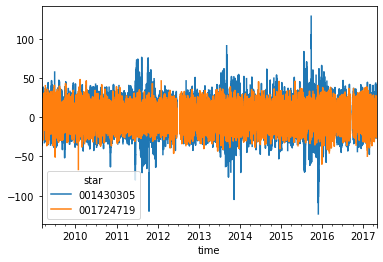

In [20]:
dataframe.iloc[:, :2].plot()

## Forecasting with Machine Learning

We need two forecast in this data, if you look with attention you'll see micro holes and big holes.

In [21]:
T = TypeVar("T")

In [22]:
class Pair(NamedTuple):
    x: T
    y: T

In [23]:
class TrainSplit(NamedTuple):
    train: T
    validation: T

In [24]:
gg.theme_set(gg.theme_bw())
warnings.filterwarnings("ignore")

(0.0, 1.0, 0.0, 1.0)

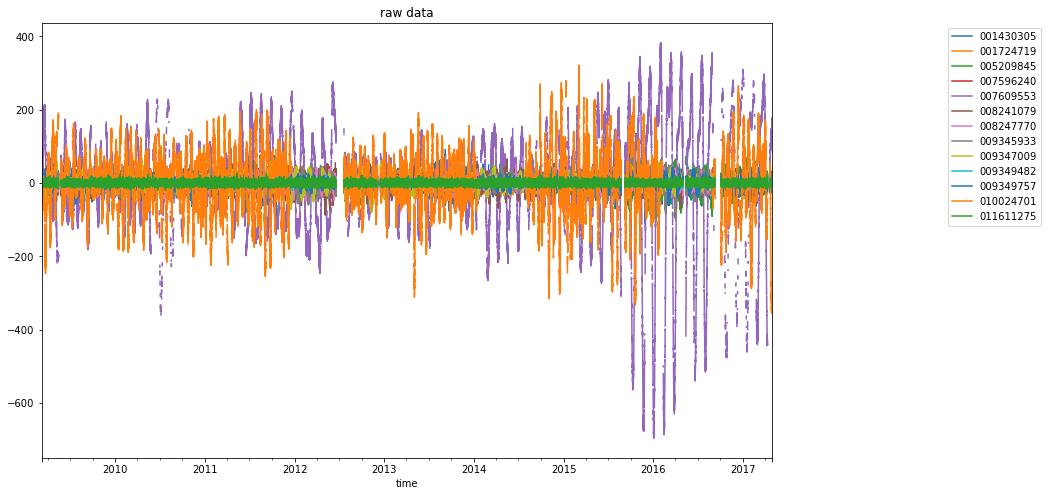

In [25]:
plt.rcParams["figure.figsize"] = 18, 8
fig, (ax, lax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [4, 1]})
dataframe.plot(ax=ax, title="raw data")
ax.legend(bbox_to_anchor=(0, 0, 1, 1), bbox_transform=lax.transAxes)
lax.axis("off")

(0.0, 1.0, 0.0, 1.0)

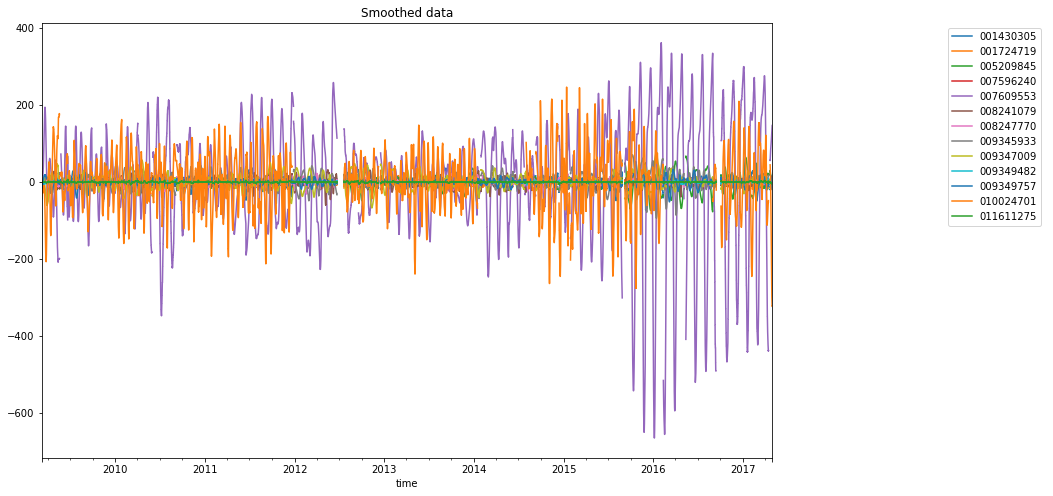

In [26]:
plt.rcParams["figure.figsize"] = 18, 8
fig, (ax, lax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [4, 1]})
dataframe_mean.plot(ax=ax, title="Smoothed data")
ax.legend(bbox_to_anchor=(0, 0, 1, 1), bbox_transform=lax.transAxes)
lax.axis("off")
# -

### Normalize data

<AxesSubplot:>

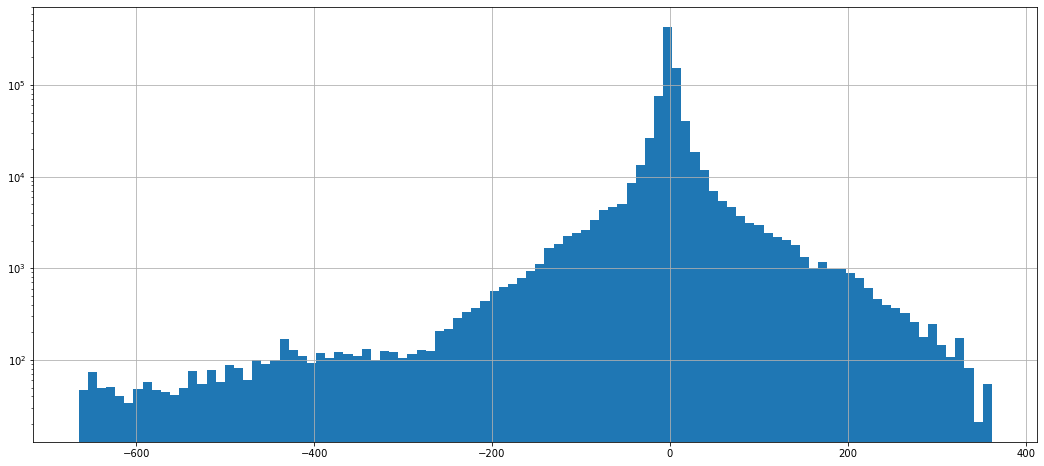

In [27]:
dataframe_mean.stack().hist(bins=100, log=True)

In [28]:
def min_max_scaler(values: pd.DataFrame, output_format: str = "dataframe") -> Encoder:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(values)
    index = values.index
    columns = values.columns

    def encode(dataframe: pd.DataFrame):
        nonlocal index
        nonlocal columns

        index = dataframe.index
        columns = dataframe.columns
        array_normed = scaler.transform(dataframe)

        if output_format == "dataframe":
            return pd.DataFrame(array_normed, index, columns)
        elif output_format == "jax":
            return jnp.array(array_normed)
        else:
            return array_normed

    def decode(array_scaled):
        value = scaler.inverse_transform(array_scaled)

        if output_format == "dataframe":
            return pd.DataFrame(value, index, columns)
        else:
            return value

    return Encoder(encode, decode)

-

In [29]:
scaler = min_max_scaler(dataframe_mean)
dataframe_normed = scaler.encode(dataframe_mean)
assert (scaler.decode(dataframe_normed) - dataframe_mean).stack().abs().max() < 1.0e-4

<AxesSubplot:>

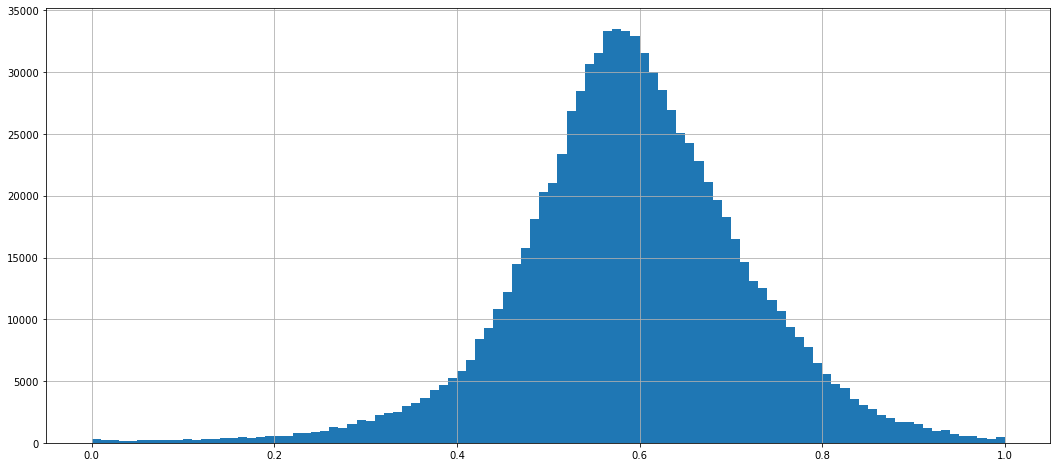

In [30]:
dataframe_normed.stack().hist(bins=100)

### Prepare train / validation datasets

In [31]:
def split_feature_target(
    dataframe,
    look_back=SEQ_LEN,
    shuffle=True,
    stack=True,
    min_periods_ratio: float = 0.8,
    rng=None,
) -> Pair:
    def prepare_xy(data):
        buffer = Buffer(look_back + 1)(data)
        x = buffer[:-1]
        y = buffer[-1]
        return x, y

    def prepare_xy(data):
        y = Buffer(look_back)(data)
        x = Lag(1)(y)
        return x, y

    x, y = unroll(prepare_xy)(jax.device_put(dataframe.values))

    if shuffle:
        if rng is None:
            rng = jax.random.PRNGKey(42)

        B = x.shape[0]
        idx = jnp.arange(B)
        idx = jax.random.shuffle(rng, idx)

        x = x[idx]
        y = y[idx]

    if stack:
        B, T, F = x.shape
        x = x.transpose(1, 0, 2).reshape(T, B * F, 1).transpose(1, 0, 2)
        y = y.transpose(1, 0, 2).reshape(T, B * F, 1).transpose(1, 0, 2)

    if min_periods_ratio:
        T = x.shape[1]
        count_nan = jnp.isnan(x).sum(axis=1)
        mask = count_nan < min_periods_ratio * T
        idx = jnp.where(mask)
        x = x[idx[0]]
        y = y[idx[0]]

    # round Batch size to a power of to
    B = x.shape[0]
    B_round = int(2 ** jnp.floor(jnp.log2(B)))
    print(f"{B} batches rounded to {B_round} batches.")
    x = x[:B_round]
    y = y[:B_round]

    # fillnan by zeros
    x, y = hk.testing.transform_and_run(lambda x: FillNanInf()(x))((x, y))

    return Pair(x, y)

In [32]:
# split_feature_target(dataframe)

In [33]:
def split_train_validation(
    dataframe, train_size, look_back, scaler: Optional[Callable] = None
) -> TrainSplit:
    # prepare scaler
    train_df = dataframe.iloc[:train_size]

    if scaler:
        scaler = scaler(train_df)

    # prepare train data
    if scaler:
        train_df = scaler.encode(train_df)

    train_xy = split_feature_target(train_df, look_back)

    # prepare validation data
    valid_size = len(dataframe) - train_size
    valid_size = int(2 ** jnp.floor(jnp.log2(valid_size)))

    valid_end = int(train_size + valid_size)
    valid_df = dataframe.iloc[train_size:valid_end]

    if scaler:
        valid_df = scaler.encode(valid_df)

    valid_xy = split_feature_target(valid_df, look_back)

    return TrainSplit(train_xy, valid_xy)

In [34]:
TRAIN_SIZE

65536

In [35]:
print(f"Look at star: {STAR}")
train, valid = split_train_validation(dataframe_normed[[STAR]], TRAIN_SIZE, SEQ_LEN)

Look at star: 007609553
63871 batches rounded to 32768 batches.
3597 batches rounded to 2048 batches.


In [36]:
train[0].shape, train[1].shape, valid[0].shape, valid[1].shape

((32768, 64, 1), (32768, 64, 1), (2048, 64, 1), (2048, 64, 1))

In [37]:
# TRAIN_SIZE, VALID_SIZE = len(train.x), len(valid.x)
print(
    f"effective train_size = {len(train.x)}, " f"effective valid size= {len(valid.x)}"
)

effective train_size = 32768, effective valid size= 2048


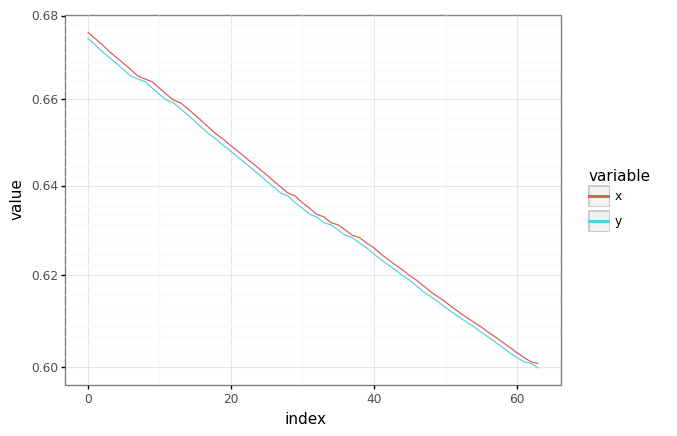

In [38]:
# Plot an observation/target pair.
rng = jax.random.PRNGKey(42)
batch_plot = jax.random.choice(rng, len(train[0]))
df = pd.DataFrame(
    {"x": train.x[batch_plot, :, 0], "y": train.y[batch_plot, :, 0]}
).reset_index()
df = pd.melt(df, id_vars=["index"], value_vars=["x", "y"])
plot = (
    gg.ggplot(df)
    + gg.aes(x="index", y="value", color="variable")
    + gg.geom_line()
    + gg.scales.scale_y_log10()
)
_ = plot.draw()

### Dataset iterator

In [39]:
class Dataset:
    """An iterator over a numpy array, revealing batch_size elements at a time."""

    def __init__(self, xy: Pair, batch_size: int):
        self._x, self._y = xy
        self._batch_size = batch_size
        self._length = self._x.shape[0]
        self._idx = 0
        if self._length % batch_size != 0:
            msg = "dataset size {} must be divisible by batch_size {}."
            raise ValueError(msg.format(self._length, batch_size))

    def __next__(self) -> Pair:
        start = self._idx
        end = start + self._batch_size
        x, y = self._x[start:end], self._y[start:end]
        if end >= self._length:
            print(f"End of the data set (size={end}). Return to the beginning.")
            end = end % self._length
            assert end == 0  # Guaranteed by ctor assertion.
        self._idx = end
        return Pair(x, y)

### Training an LSTM

To train the LSTM, we define a Haiku function which unrolls the LSTM over the input sequence, generating predictions for all output values. The LSTM always starts with its initial state at the start of the sequence.

The Haiku function is then transformed into a pure function through `hk.transform`, and is trained with Adam on an L2 prediction loss.

In [40]:
def unroll_net(seqs: jnp.ndarray):
    """Unrolls an LSTM over seqs, mapping each output to a scalar."""
    # seqs is [T, B, F].
    core = hk.LSTM(32)
    batch_size = seqs.shape[0]
    outs, state = hk.dynamic_unroll(
        core, seqs, core.initial_state(batch_size), time_major=False
    )
    # We could include this Linear as part of the recurrent core!
    # However, it's more efficient on modern accelerators to run the linear once
    # over the entire sequence than once per sequence element.
    return hk.BatchApply(hk.Linear(1))(outs), state

In [41]:
model = jit_init_apply(hk.transform(unroll_net))

In [42]:
@jax.jit
def loss(pred, y):
    return jnp.mean(jnp.square(pred - y))


def model_with_loss(x, y):
    pred, _ = unroll_net(x)
    return loss(pred, y)

In [43]:
class TrainState(NamedTuple):
    step: int
    params: Any
    opt_state: Any
    rng: jnp.ndarray
    loss: float


def train_model(
    model_with_loss: Callable,
    train_ds: Dataset,
    valid_ds: Dataset,
    max_iterations: int = -1,
    rng=None,
    record_freq=100,
) -> hk.Params:
    """Initializes and trains a model on train_ds, returning the final params."""
    opt = optax.adam(1e-3)
    model_with_loss = jit_init_apply(hk.transform(model_with_loss))

    @jax.jit
    def update(train_state, x, y):
        step, params, opt_state, rng, _ = train_state
        if rng is not None:
            (rng,) = jax.random.split(rng, 1)
        l, grads = jax.value_and_grad(model_with_loss.apply)(params, rng, x, y)
        grads, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, grads)
        return TrainState(step + 1, params, opt_state, rng, l)

    # Initialize state.
    def init():
        x, y = next(train_ds)
        params = model_with_loss.init(rng, x, y)
        opt_state = opt.init(params)
        return TrainState(0, params, opt_state, rng, jnp.inf)

    def _format_results(records):
        records = {key: jnp.stack(l) for key, l in records.items()}
        return records

    records = defaultdict(list)
    train_state = init()
    with tqdm(total=max_iterations if max_iterations > 0 else None) as pbar:
        while True:
            try:
                x, y = next(train_ds)
            except StopIteration:
                return train_state, _format_results(records)

            train_state = update(train_state, x, y)
            if train_state.step % record_freq == 0:
                x, y = next(valid_ds)
                if rng is not None:
                    (rng,) = jax.random.split(rng, 1)
                valid_loss = model_with_loss.apply(train_state.params, rng, x, y)
                records["step"].append(train_state.step)
                records["valid_loss"].append(valid_loss)
                records["train_loss"].append(train_state.loss)

            pbar.update()
            if max_iterations > 0 and train_state.step >= max_iterations:
                return train_state, _format_results(records)

In [44]:
%%time
train, valid = split_train_validation(dataframe_normed[[STAR]], TRAIN_SIZE, SEQ_LEN)
train_ds = Dataset(train, BATCH_SIZE)
valid_ds = Dataset(valid, BATCH_SIZE)


train_state, records = train_model(
    model_with_loss,
    train_ds,
    valid_ds,
    len(train.x) // BATCH_SIZE * NUM_EPOCHS,
    rng=jax.random.PRNGKey(42),
    record_freq=RECORD_FREQ,
)

63871 batches rounded to 32768 batches.
3597 batches rounded to 2048 batches.


  0%|          | 0/40960 [00:00<?, ?it/s]

End of the data set (size=32768). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
End of the data set (size=2048). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
End of the data set (size=32768). Return to the beginning.
CPU times: user 58.6 s, sys: 371 ms, total: 59 s
Wall time: 58.8 s


In [45]:
# train_state.params

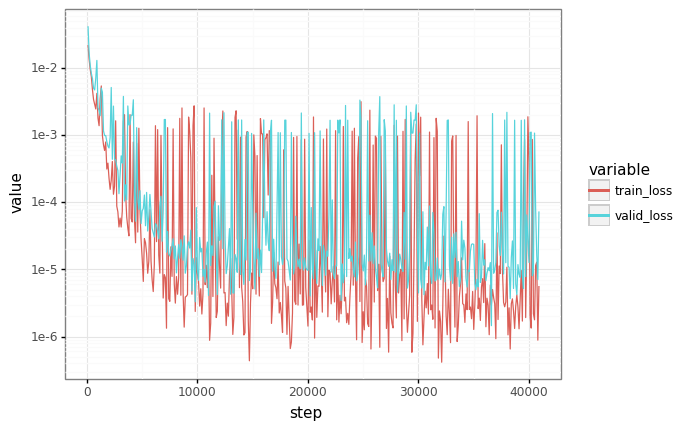

In [46]:
# Plot losses
losses = pd.DataFrame(records)
df = pd.melt(losses, id_vars=["step"], value_vars=["train_loss", "valid_loss"])
plot = (
    gg.ggplot(df)
    + gg.aes(x="step", y="value", color="variable")
    + gg.geom_line()
    + gg.scales.scale_y_log10()
)
_ = plot.draw()

### Sampling

The point of training models is so that they can make predictions! How can we generate predictions with the trained model?

If we're allowed to feed in the ground truth, we can just run the original model's `apply` function.

In [47]:
def plot_samples(truth: np.ndarray, prediction: np.ndarray) -> gg.ggplot:
    assert truth.shape == prediction.shape
    df = pd.DataFrame(
        {"truth": truth.squeeze(), "predicted": prediction.squeeze()}
    ).reset_index()
    df = pd.melt(df, id_vars=["index"], value_vars=["truth", "predicted"])
    plot = (
        gg.ggplot(df) + gg.aes(x="index", y="value", color="variable") + gg.geom_line()
    )
    return plot

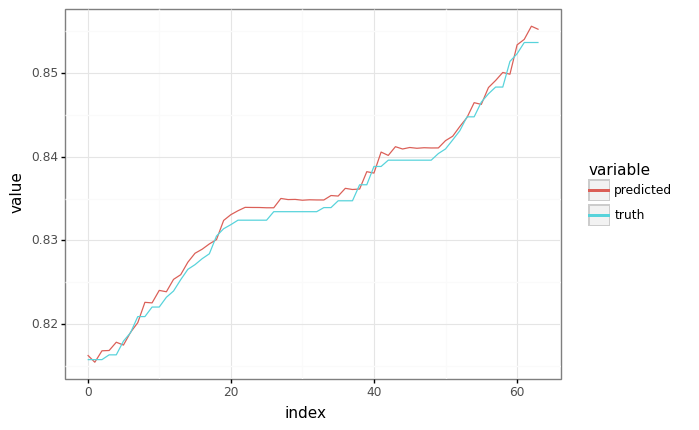

In [48]:
# Grab a sample from the validation set.
sample_x, sample_y = next(valid_ds)
sample_x = sample_x[:1]  # Shrink to batch-size 1.
sample_y = sample_y[:1]

# Generate a prediction, feeding in ground truth at each point as input.
predicted, _ = model.apply(train_state.params, None, sample_x)

plot = plot_samples(sample_y, predicted)
plot.draw()
del sample_x, predicted

### Run autoregressively

If we can't feed in the ground truth (because we don't have it), we can also run the model autoregressively.

In [49]:
def autoregressive_predict(
    trained_params: hk.Params,
    context: jnp.ndarray,
    seq_len: int,
    pbar=False,
):
    """Given a context, autoregressively generate the rest of a sine wave."""

    ar_outs = []
    context = jax.device_put(context)
    times = onp.arange(seq_len - context.shape[1] + 1)
    if pbar:
        times = tqdm(times)
    for _ in times:
        full_context = jnp.concatenate([context] + ar_outs, axis=1)

        outs, _ = model.apply(trained_params, None, full_context)
        # Append the newest prediction to ar_outs.
        ar_outs.append(outs[:, -1:, :])
    # Return the final full prediction.
    return outs

In [50]:
sample_x, sample_y = next(valid_ds)
sample_x = sample_x[:1]  # Shrink to batch-size 1.
sample_y = sample_y[:1]  # Shrink to batch-size 1.


context_length = SEQ_LEN // 8
print(f"context_length = {context_length}")
# Cut the batch-size 1 context from the start of the sequence.
context = sample_x[:, :context_length]

context_length = 8


In [51]:
%%time
# We can reuse params we got from training for inference - as long as the
# declaration order is the same.
predicted = autoregressive_predict(train_state.params, context, SEQ_LEN, pbar=True)

  0%|          | 0/57 [00:00<?, ?it/s]

CPU times: user 7.5 s, sys: 123 ms, total: 7.63 s
Wall time: 7.56 s


In [52]:
sample_y.shape, predicted.shape

((1, 64, 1), (1, 64, 1))

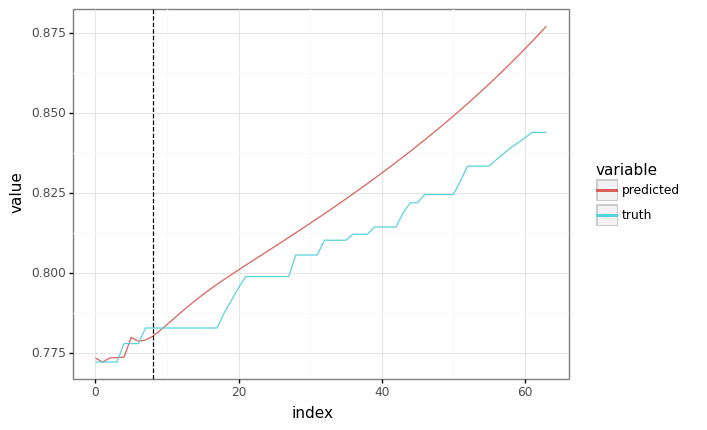

In [53]:
plot = plot_samples(sample_y, predicted)
plot += gg.geom_vline(xintercept=context.shape[1], linetype="dashed")
_ = plot.draw()

#### Sharing parameters with a different function.

Unfortunately, this is a bit slow - we're doing O(N^2) computation for a sequence of length N.

It'd be better if we could do the autoregressive sampling all at once - but we need to write a new Haiku function for that.

We're in luck - if the Haiku module names match, the same parameters can be used for multiple Haiku functions.

This can be achieved through a combination of two techniques:

1. If we manually give a unique name to a module, we can ensure that the parameters are directed to the right places.
2. If modules are instantiated in the same order, they'll have the same names in different functions.

Here, we rely on method #2 to create a fast autoregressive prediction.

In [54]:
@hk.transform
def fast_autoregressive_predict_fn(context, seq_len):
    """Given a context, autoregressively generate the rest of a sine wave."""
    core = hk.LSTM(32)
    dense = hk.Linear(1)
    state = core.initial_state(context.shape[0])
    # Unroll over the context using `hk.dynamic_unroll`.
    # As before, we `hk.BatchApply` the Linear for efficiency.
    context_outs, state = hk.dynamic_unroll(
        core,
        context,
        state,
        time_major=False,
    )
    context_outs = hk.BatchApply(dense)(context_outs)

    # Now, unroll one step at a time using the running recurrent state.
    ar_outs = []
    x = context_outs[:, -1, :]
    times = range(seq_len - context.shape[1])
    for _ in times:
        x, state = core(x, state)
        x = dense(x)
        ar_outs.append(x)
    ar_outs = jnp.stack(ar_outs)
    ar_outs = ar_outs.transpose(1, 0, 2)
    return jnp.concatenate([context_outs, ar_outs], axis=1)


fast_autoregressive_predict = jax.jit(
    fast_autoregressive_predict_fn.apply, static_argnums=(3,)
)

In [55]:
%%time
# Reuse the same context from the previous cell.
predicted = fast_autoregressive_predict(train_state.params, None, context, SEQ_LEN)

CPU times: user 24.6 s, sys: 54.8 ms, total: 24.6 s
Wall time: 24.6 s


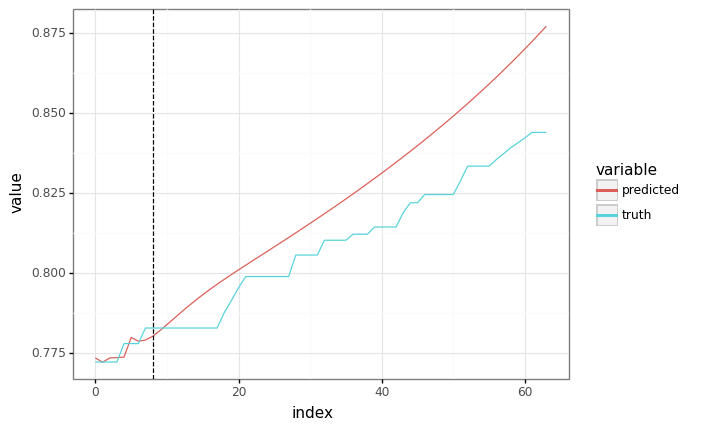

In [56]:
# The plots should be equivalent!
plot = plot_samples(sample_y, predicted)
plot += gg.geom_vline(xintercept=context.shape[1], linetype="dashed")
_ = plot.draw()

# Sample trajectories

context_length = 8


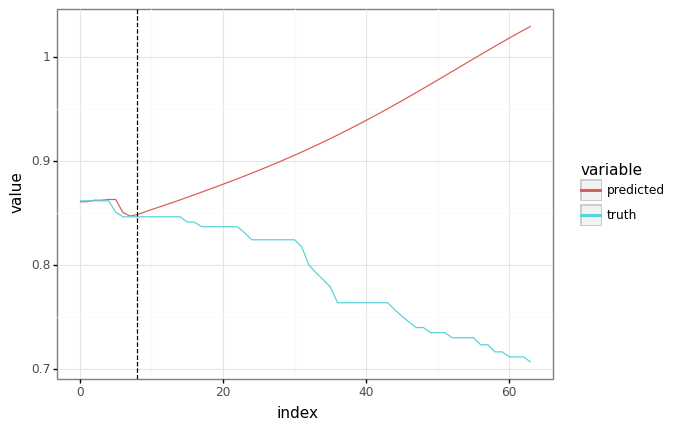

In [57]:
sample_x, sample_y = next(valid_ds)
sample_x = sample_x[:1]  # Shrink to batch-size 1.
sample_y = sample_y[:1]  # Shrink to batch-size 1.


context_length = SEQ_LEN // 8
print(f"context_length = {context_length}")
# Cut the batch-size 1 context from the start of the sequence.
context = sample_x[:, :context_length]

# Reuse the same context from the previous cell.
predicted = fast_autoregressive_predict(train_state.params, None, context, SEQ_LEN)

# The plots should be equivalent!
plot = plot_samples(sample_y, predicted)
plot += gg.geom_vline(xintercept=context.shape[1], linetype="dashed")
_ = plot.draw()

## timeit

In [58]:
%timeit autoregressive_predict(train_state.params, context, SEQ_LEN)
%timeit fast_autoregressive_predict(train_state.params, None, context, SEQ_LEN)

32.4 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
25 µs ± 90.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Train all stars

### Training

In [59]:
def split_train_validation_date(dataframe, date, look_back) -> TrainSplit:
    train_size = len(dataframe.loc[:date])
    return split_train_validation(dataframe, train_size, look_back)

In [60]:
%%time
train, valid = split_train_validation_date(dataframe_normed, TRAIN_DATE, SEQ_LEN)
print(f"effective train size = {train[0].shape[1]}")

838194 batches rounded to 524288 batches.
26455 batches rounded to 16384 batches.
effective train size = 64
CPU times: user 2.65 s, sys: 743 ms, total: 3.39 s
Wall time: 2.82 s


In [61]:
train[0].shape, train[1].shape, valid[0].shape, valid[1].shape

((524288, 64, 1), (524288, 64, 1), (16384, 64, 1), (16384, 64, 1))

In [62]:
train_ds = Dataset(train, BATCH_SIZE)
valid_ds = Dataset(valid, BATCH_SIZE)
# del train, valid  # Don't leak temporaries.

In [63]:
%%time
train_state, records = train_model(
    model_with_loss,
    train_ds,
    valid_ds,
    len(train.x) // BATCH_SIZE * 1,
    jax.random.PRNGKey(42),
    record_freq=RECORD_FREQ,
)

  0%|          | 0/65536 [00:00<?, ?it/s]

End of the data set (size=524288). Return to the beginning.
CPU times: user 1min 30s, sys: 408 ms, total: 1min 30s
Wall time: 1min 30s


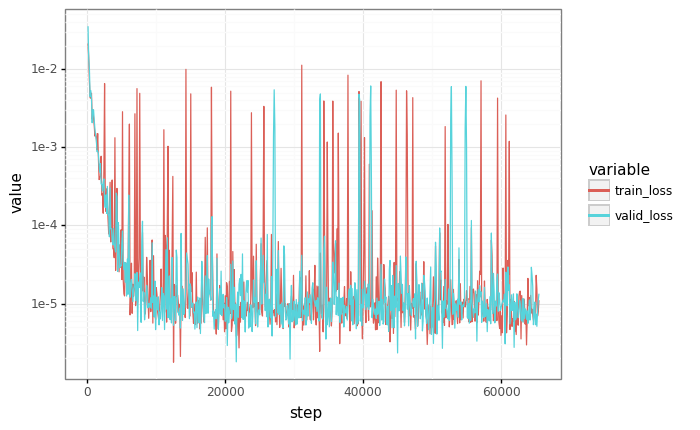

In [64]:
# Plot losses
losses = pd.DataFrame(records)
df = pd.melt(losses, id_vars=["step"], value_vars=["train_loss", "valid_loss"])
plot = (
    gg.ggplot(df)
    + gg.aes(x="step", y="value", color="variable")
    + gg.geom_line()
    + gg.scales.scale_y_log10()
)
_ = plot.draw()

### Sampling

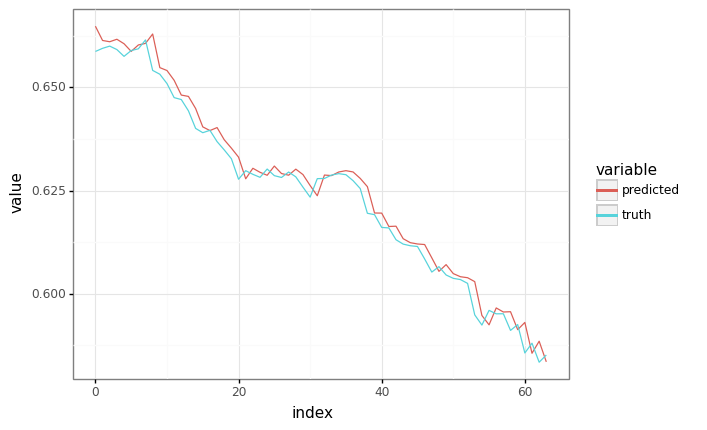

In [65]:
# Grab a sample from the validation set.
sample_x, sample_y = next(valid_ds)
sample_x = sample_x[:1]  # Shrink to batch-size 1.
sample_y = sample_y[:1]  # Shrink to batch-size 1.


# Generate a prediction, feeding in ground truth at each point as input.
predicted, _ = model.apply(train_state.params, None, sample_x)

plot = plot_samples(sample_y, predicted)
_ = plot.draw()

### Run autoregressively

CPU times: user 64.6 ms, sys: 2.56 ms, total: 67.2 ms
Wall time: 65.8 ms


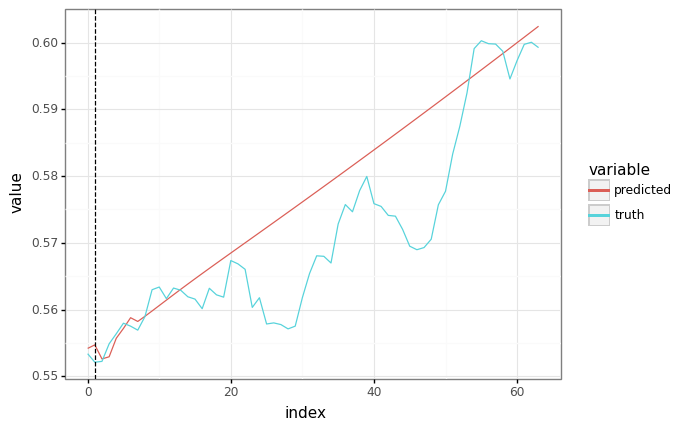

In [66]:
%%time
sample_x, sample_y = next(valid_ds)
sample_x = sample_x[:1]  # Shrink to batch-size 1.
sample_y = sample_y[:1]  # Shrink to batch-size 1.


context_length = SEQ_LEN // 8
# Cut the batch-size 1 context from the start of the sequence.
context = sample_x[:, :context_length]

# Reuse the same context from the previous cell.
predicted = fast_autoregressive_predict(train_state.params, None, context, SEQ_LEN)

# The plots should be equivalent!
plot = plot_samples(sample_y, predicted)
plot += gg.geom_vline(xintercept=len(context), linetype="dashed")
_ = plot.draw()